In [30]:

import pandas as pd
import numpy as np
import os 
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report

In [7]:
#!pip install transformers

In [2]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [19]:
train = pd.read_csv('train.csv')

In [8]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

In [9]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # KM: detect and init the TPU: TPUClusterResolver() locates the TPUs on the network
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu) # KM: "strategy" contains the necessary distributed training code that will work on the TPUs
except ValueError: # KM: in case Accelerator is not set to TPU in the Notebook Settings
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync) # KM: returns the number of cores

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.104.57.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.104.57.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [10]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name) # KM: this is the tokenizer we will use on our text data to tokenize it

In [12]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s)) # KM: split the sentence into tokens that are either words or sub-words
   tokens.append('[SEP]') # KM: a token called [SEP] (=separator) is added to mark end of each sentence
   return tokenizer.convert_tokens_to_ids(tokens) # KM: instead of returning the list of tokens, a list of each token ID is returned

In [13]:
def bert_encode(hypotheses, premises, tokenizer, max_length=80):

    x = [h + ' [SEP] ' + p for h, p in zip(np.array(hypotheses), np.array(premises))]
    x = tokenizer(x, padding=True, truncation=True, max_length=max_length)

    inputs = {
          'input_word_ids':tf.ragged.constant(x['input_ids']).to_tensor(),
          'input_mask': tf.ragged.constant(x['attention_mask']).to_tensor(),
          'input_type_ids': tf.ragged.constant(x['token_type_ids']).to_tensor()}

    return inputs

In [14]:
max_len = 80
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:

with strategy.scope():
    model = build_model()
    model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 80)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [22]:
train_input = bert_encode(train.hypothesis.values, train.premise.values,  tokenizer)

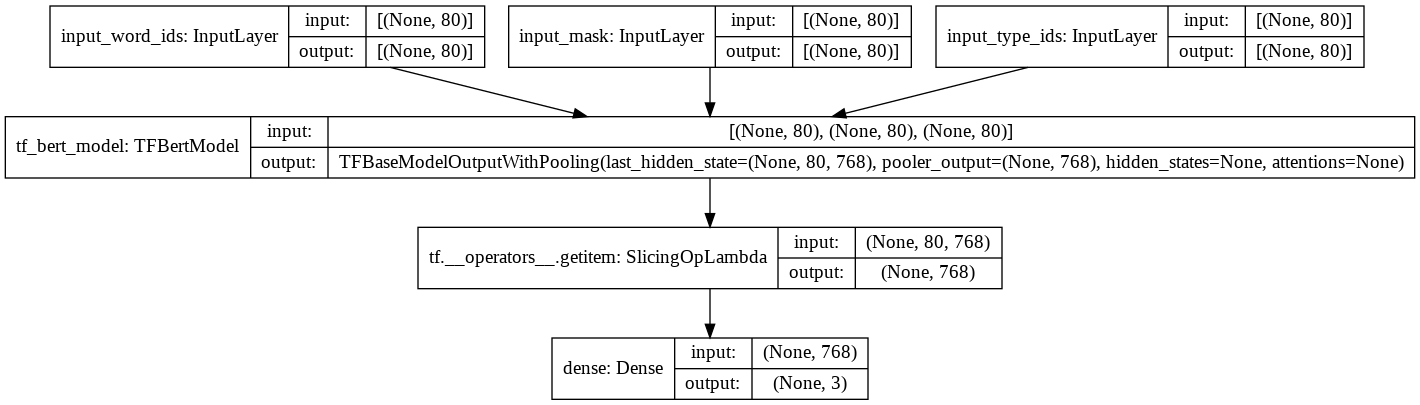

In [16]:
tf.keras.utils.plot_model(model, "my_model.png", show_shapes=True) # KM: I added this line because it gives a nice visualization showing the individual components of our model

In [23]:
model.fit(train_input, train.label.values, epochs = 2, verbose = 1, batch_size = 64, validation_split = 0.2)

Epoch 1/2


152/152 [==============================] - ETA: 0s - loss: 1.1245 - accuracy: 0.3738WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


152/152 [==============================] - 128s 414ms/step - loss: 1.1242 - accuracy: 0.3742 - val_loss: 0.9561 - val_accuracy: 0.5487
Epoch 2/2
152/152 [==============================] - 16s 105ms/step - loss: 0.9179 - accuracy: 0.5664 - val_loss: 0.8976 - val_accuracy: 0.5903


In [24]:
predictions_train = [np.argmax(i) for i in model.predict(train_input)] 

In [33]:
y_true = train.label
y_pred = predictions_train
#target_names = [0,1,2]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.51      0.63      4176
           1       0.61      0.76      0.68      3880
           2       0.62      0.72      0.66      4064

    accuracy                           0.66     12120
   macro avg       0.69      0.66      0.66     12120
weighted avg       0.69      0.66      0.66     12120

